In [19]:
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [20]:
# 改成你其中一个文件的路径
sample_path = "~/Desktop/Cases_1/苏州工业园/Electric power load data/2018/1_hour/2018_1hour_Office/20180101_1hour_Office.xlsx"
sample_path = os.path.expanduser(sample_path)

# 读取文件头部几行
df = pd.read_excel(sample_path)
print("列名如下：")
print(df.columns)

# 设置文件夹路径
folder_path = os.path.expanduser("~/Desktop/Cases_1/苏州工业园/Electric power load data/2018/1_hour/2018_1hour_Office")

# 获取所有 .xlsx 文件
file_list = sorted([f for f in os.listdir(folder_path) if f.endswith('.xlsx')])

# 创建空 DataFrame 用于合并
combined_df = pd.DataFrame()

# 遍历每个文件
for filename in file_list:
    try:
        file_path = os.path.join(folder_path, filename)
        df = pd.read_excel(file_path, engine='openpyxl')  # 显式指定 engine
        
        # 标准化列名
        df.columns = [col.strip().replace('\n', '').replace('\r', '').lower() for col in df.columns]
        #  print(f"✔ 读取 {filename} 的列名为：{df.columns.tolist()}")
        
        # 判断列名是否存在
        if 'time' in df.columns and 'power (kw)' in df.columns:
            df = df[['time', 'power (kw)']]
            df['SourceFileDate'] = filename[:8]
            
            # 转换类型
            df['time'] = pd.to_datetime(df['time'])
            df['SourceFileDate'] = pd.to_datetime(df['SourceFileDate'])
            
            combined_df = pd.concat([combined_df, df], ignore_index=True)
        else:
            raise ValueError("列名不符合预期：'time' 和 'power (kw)' 不存在")
    
    except Exception as e:
        print(f"跳过文件 {filename}, 原因: {e}")


# 保存最终合并的 CSV
combined_df.to_csv("Office_2018_1hour_long.csv", index=False)
print("成功导出为 'Office_2018_1hour_long.csv'")

列名如下：
Index(['Time', 'Power (kW)'], dtype='object')
成功导出为 'Office_2018_1hour_long.csv'


In [21]:
df = pd.read_csv("Office_2018_1hour_long.csv", encoding='utf-8-sig')
df.columns = [col.strip().lower() for col in df.columns]  # 统一小写 + 去空格

# 统一时间格式
df['time'] = pd.to_datetime(df['time'])
df['date'] = df['time'].dt.date
df['hour'] = df['time'].dt.time

# 去重，只保留第一条记录
df = df.drop_duplicates(subset=['date', 'hour'], keep='first')

# 生成每天一行，每小时一列的负载矩阵
pivot_df = df.pivot(index='date', columns='hour', values='power (kw)').reset_index()
pivot_df.to_csv("daily_load_matrix.csv", index=False)

print("已成功生成 daily_load_matrix.csv（重复已处理）")

已成功生成 daily_load_matrix.csv（重复已处理）


In [22]:
pivot_df = pd.read_csv("daily_load_matrix.csv")
# 插值 + 双向填充
pivot_df_interp = pivot_df.set_index('date')
pivot_df_interp = pivot_df_interp.interpolate(axis=1, limit_direction='both')
pivot_df_interp = pivot_df_interp.ffill(axis=1).bfill(axis=1)

# 丢掉真的没救的数据（全为空行）
pivot_df_interp = pivot_df_interp.dropna(thresh=10)  # 至少保留10小时数据
pivot_df_interp = pivot_df_interp.reset_index()

In [23]:
pivot_df_interp.shape     
pivot_df_interp.head()

,date,00:00:00,01:00:00,02:00:00,03:00:00,04:00:00,05:00:00,06:00:00,07:00:00,08:00:00,...,14:00:00,15:00:00,16:00:00,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00
0,2018-01-01,261.12,259.92,253.20,250.08,259.68,264.00,279.12,282.84,388.16,...,421.32,393.00,421.68,379.32,343.08,301.08,314.40,272.40,243.84,239.64
1,2018-01-02,235.56,252.36,228.24,231.24,238.44,236.88,282.36,806.40,1017.68,...,1137.24,1104.36,1099.80,1030.92,538.56,375.00,356.76,321.96,256.92,219.36
2,2018-01-03,210.84,222.12,218.28,213.36,217.68,219.48,372.36,811.68,962.28,...,1193.40,1225.44,1154.04,1133.76,545.52,398.28,360.48,274.08,258.24,225.00
3,2018-01-04,222.48,228.48,215.40,222.72,216.12,224.40,334.92,813.36,1004.28,...,1209.66,1138.56,1155.96,1071.96,564.00,447.60,348.36,304.08,259.44,238.56
4,2018-01-05,241.08,234.72,231.24,226.80,219.96,232.20,303.84,817.20,977.28,...,1220.04,1140.24,1160.88,1096.32,539.04,425.28,386.28,327.15,242.16,238.32


In [24]:
X = pivot_df_interp.select_dtypes(include='number')
print(X.isna().sum().sum())  # 输出所有 NaN 的总数

0


In [25]:
X = pivot_df_interp.select_dtypes(include='number')  # 数值型列，即每小时负载值
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

pivot_df_interp['cluster'] = clusters  # 添加聚类标签

# 正确保存
pivot_df_interp.to_csv("daily_load_with_clusters_and_labels.csv", index=False)

In [26]:
print(pivot_df_interp[['date', 'cluster']].head())

         date  cluster
0  2018-01-01        1
1  2018-01-02        0
2  2018-01-03        0
3  2018-01-04        0
4  2018-01-05        0


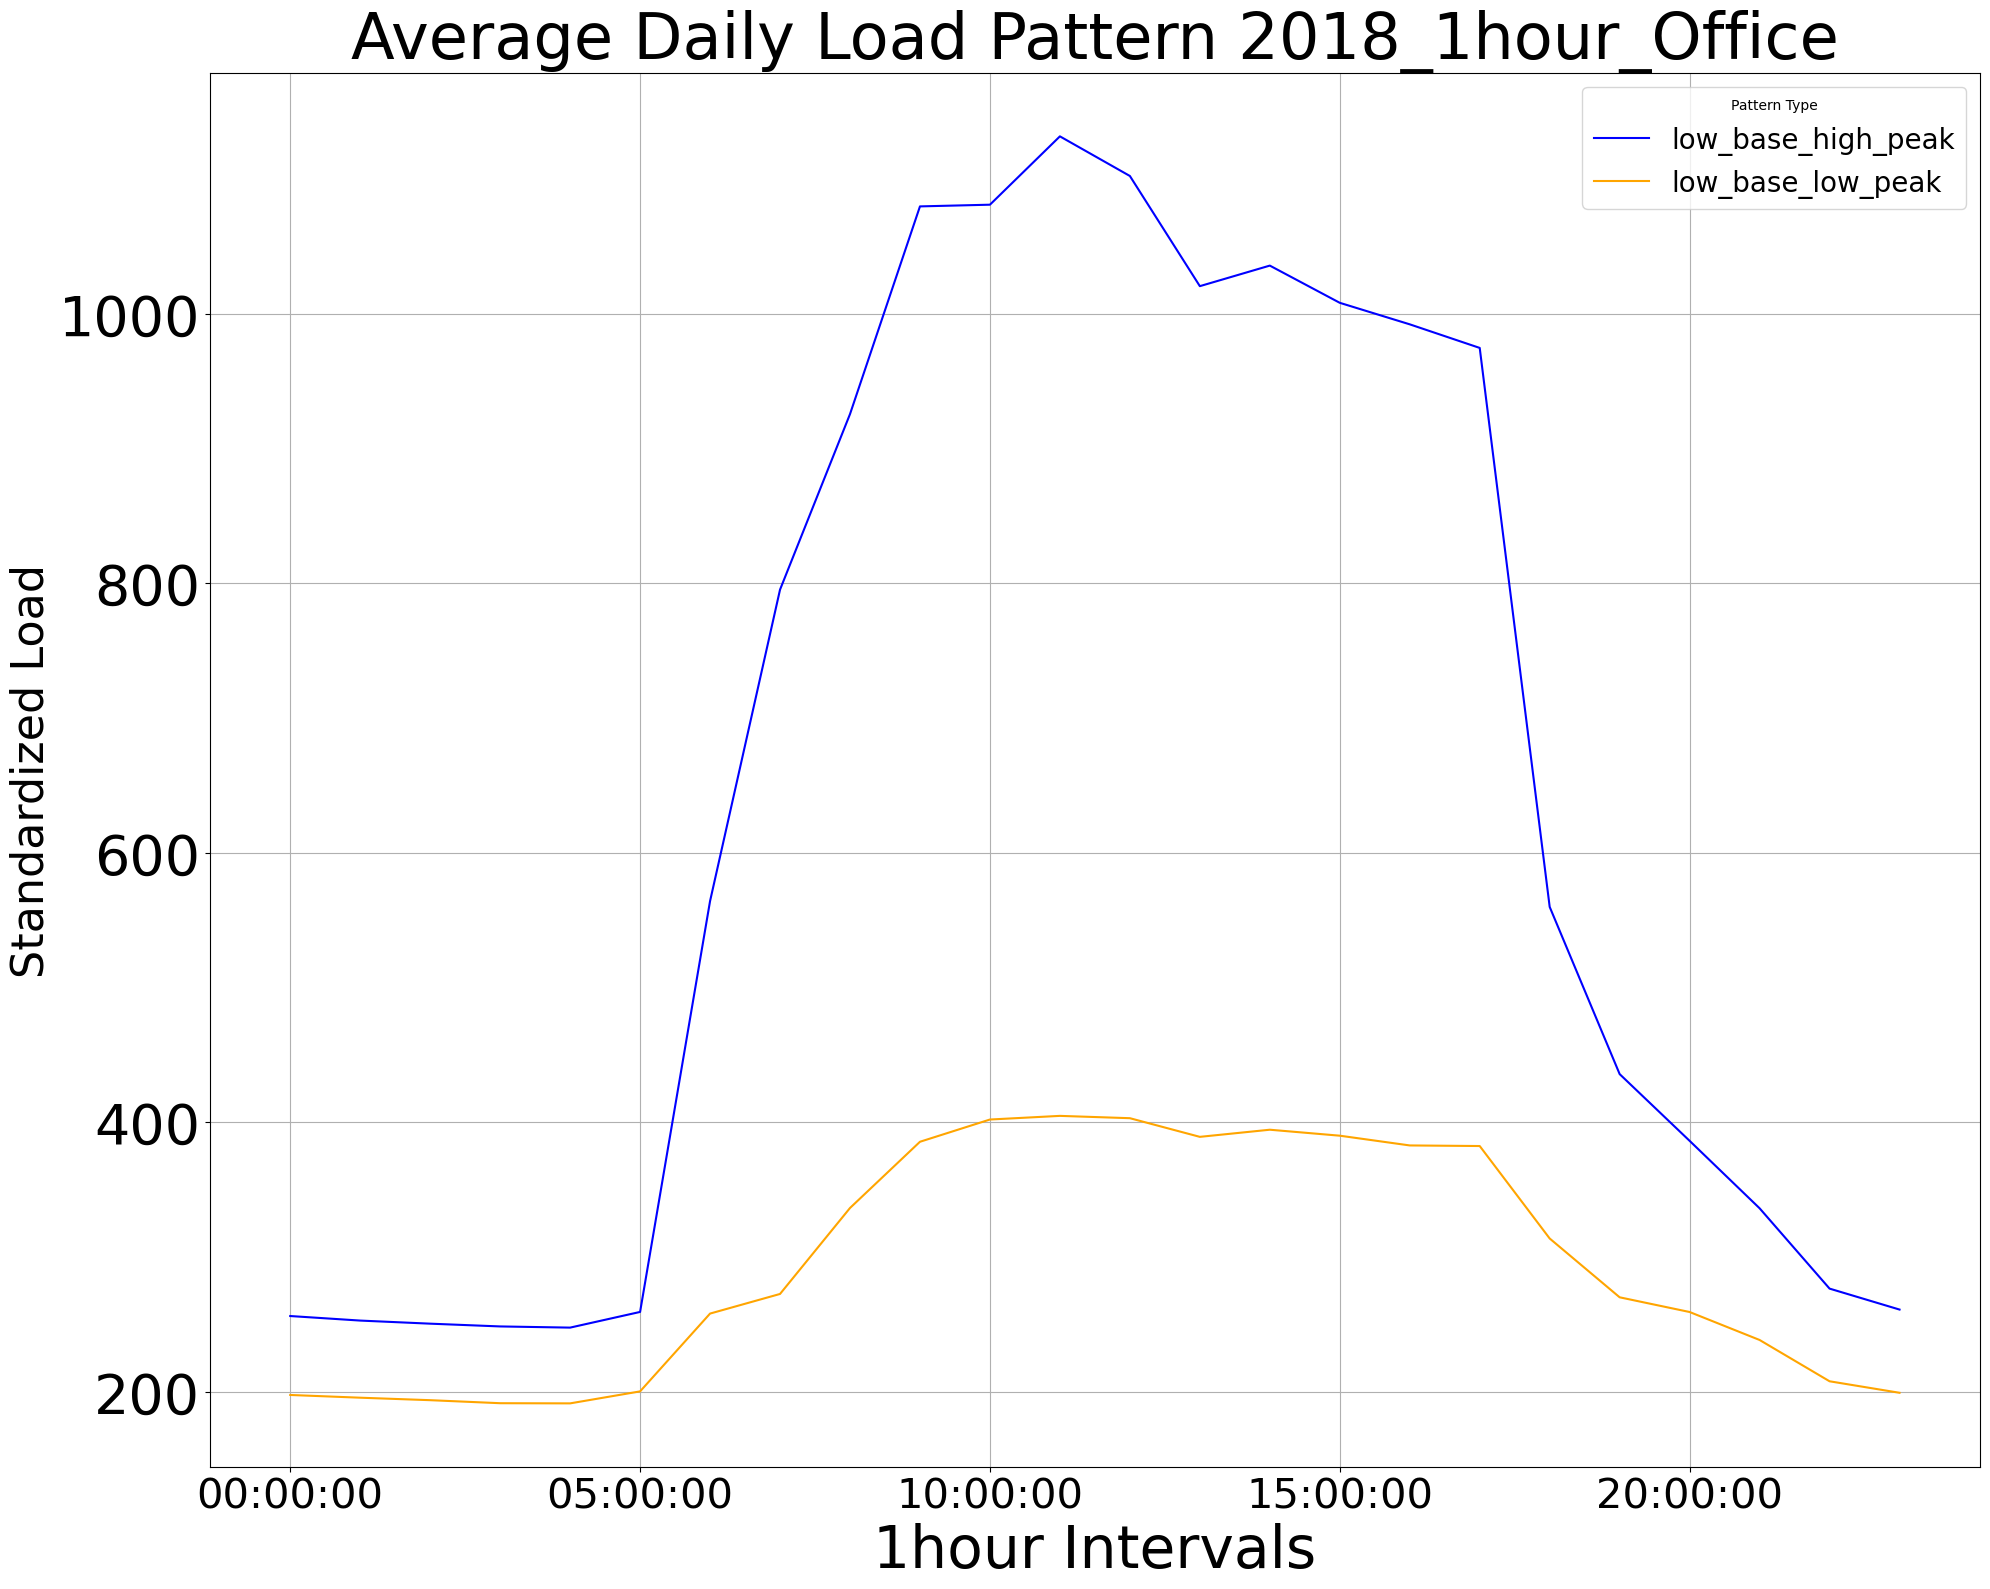

In [35]:
load_columns = pivot_df_interp.select_dtypes(include='number').columns.drop('cluster')

# Ensure clustering has been done and column exists
assert 'cluster' in pivot_df_interp.columns, "Missing 'cluster' column. Run KMeans first."

# Group by cluster, average the first 96 load columns
avg_by_label = pivot_df_interp.groupby("cluster")[load_columns].mean()

# Define custom labels
cluster_name_map = {
    0: "low_base_high_peak",
    1: "low_base_low_peak",
}
pivot_df_interp['pattern'] = pivot_df_interp['cluster'].map(cluster_name_map)
# Rename cluster index to meaningful names
avg_by_label.index = avg_by_label.index.map(cluster_name_map)

# Plot
avg_by_label.T.plot(figsize=(20, 16), color=colors)
plt.title("Average Daily Load Pattern 2018_1hour_Office", fontsize=46)
plt.xlabel("1hour Intervals", fontsize=42)
plt.ylabel("Standardized Load", fontsize=32)
plt.xticks(fontsize=30)
plt.yticks(fontsize=40)
plt.legend(title="Pattern Type", fontsize=20)
plt.grid(True)
plt.tight_layout()
plt.show()

In [28]:
cluster_name_map = {
    0: "low_base_high_peak",
    1: "low_base_low_peak",
}

for c in sorted(pivot_df_interp['cluster'].unique()):
    name = cluster_name_map[c]
    print(f"\nCluster {c} ({name}):")
    dates = pivot_df_interp[pivot_df_interp['cluster'] == c]['date'].tolist()
    print(dates[:10])



Cluster 0 (low_base_high_peak):
['2018-01-02', '2018-01-03', '2018-01-04', '2018-01-05', '2018-01-08', '2018-01-09', '2018-01-10', '2018-01-11', '2018-01-12', '2018-01-15']

Cluster 1 (low_base_low_peak):
['2018-01-01', '2018-01-06', '2018-01-07', '2018-01-13', '2018-01-14', '2018-01-20', '2018-01-21', '2018-01-27', '2018-01-28', '2018-02-03']


In [29]:
pivot_df_interp.to_csv("daily_load_with_clusters_and_labels_2018_1hour_office.csv")

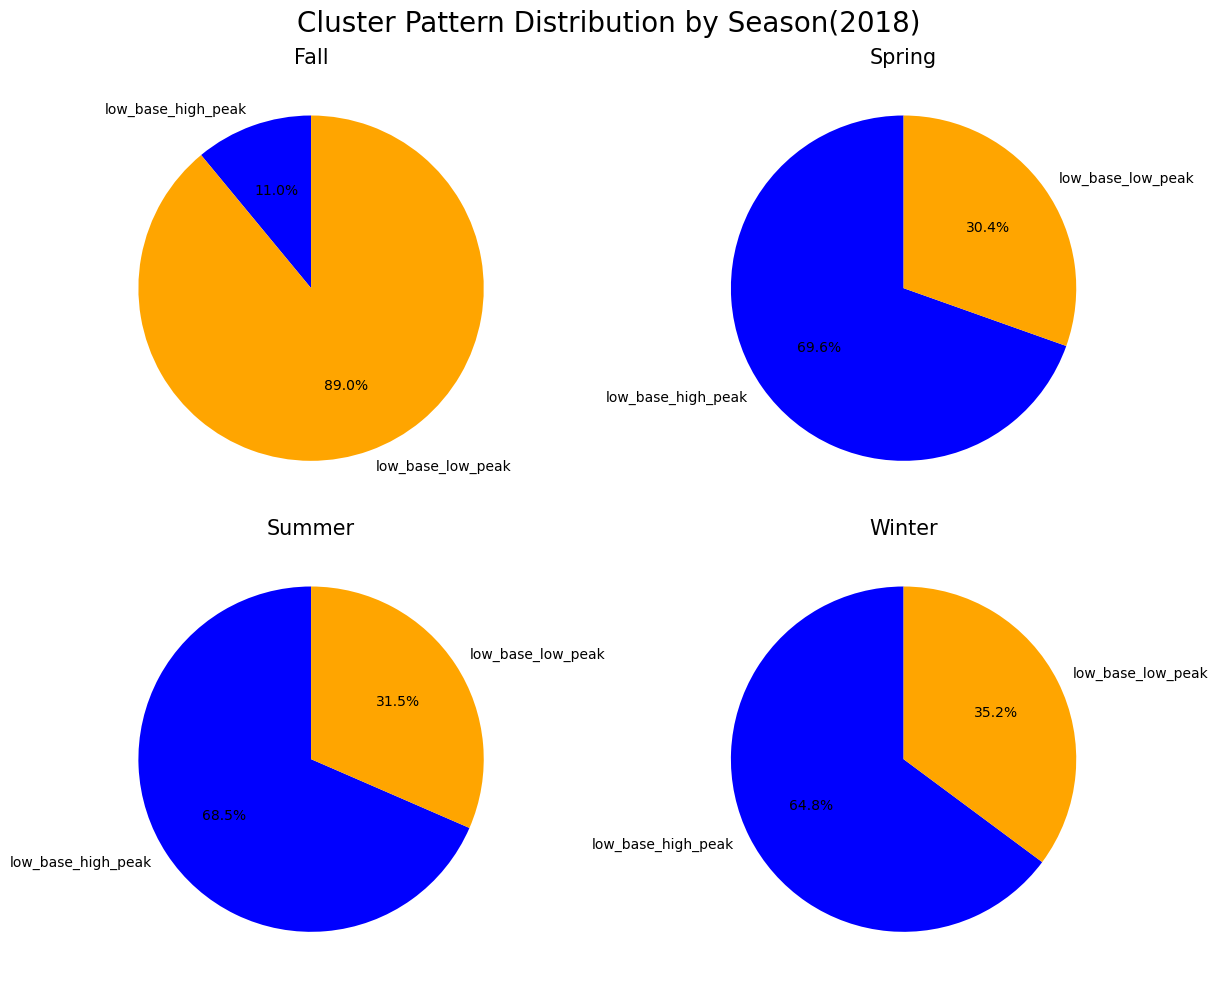

In [36]:
pivot_df_interp['date'] = pd.to_datetime(pivot_df_interp['date'])

def get_season(date):
    m = date.month
    if m in [12, 1, 2]:
        return 'Winter'
    elif m in [3, 4, 5]:
        return 'Spring'
    elif m in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

pivot_df_interp['season'] = pivot_df_interp['date'].apply(get_season)
pattern_by_season = pivot_df_interp.groupby(['season', 'pattern']).size().unstack(fill_value=0)


seasons = pattern_by_season.index.tolist()
labels = pattern_by_season.columns.tolist()

# Define color mapping
color_dict = {
    'low_base_low_peak': 'orange',
    'low_base_high_peak': 'blue'
}
# Assign default color if pattern not in the dictionary
colors = [color_dict.get(label, 'gray') for label in labels]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 2x2 grid of pie charts

for i, season in enumerate(seasons):
    ax = axes[i // 2, i % 2]
    ax.pie(
        pattern_by_season.loc[season], 
        labels=labels, 
        autopct='%1.1f%%', 
        startangle=90,
        colors=colors
    )
    ax.set_title(f"{season}",fontsize=15)

plt.suptitle("Cluster Pattern Distribution by Season(2018)",fontsize=20)
plt.tight_layout()
plt.show()

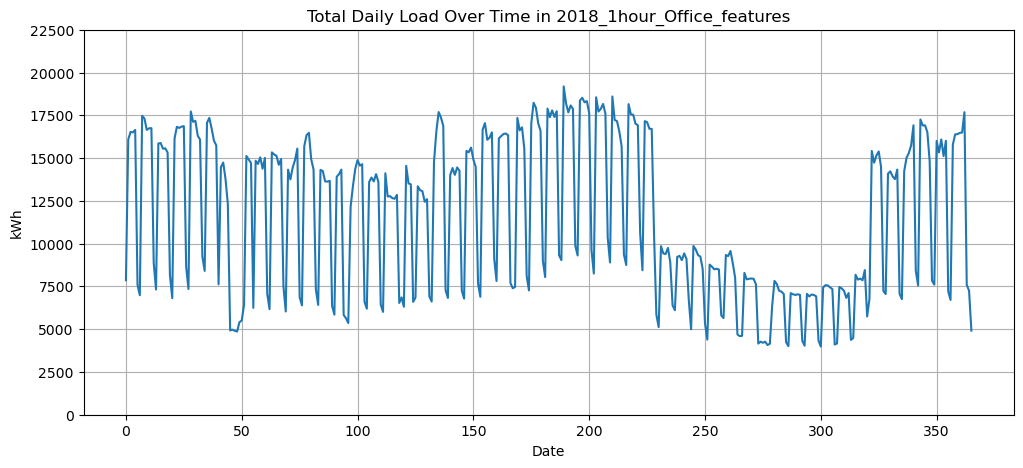

In [31]:
# 1. 完成所有预处理（插值、聚类、添加 pattern 和 season）
pivot_df_interp['pattern'] = pivot_df_interp['cluster'].map(cluster_name_map)
pivot_df_interp['season'] = pivot_df_interp['date'].apply(get_season)

# 2. 必须在这里清洗列名！所有后续都基于它！
pivot_df_interp.columns = pivot_df_interp.columns.map(str)

# 3. 抓负载列（非 date / cluster / pattern / season）
load_columns = [col for col in pivot_df_interp.columns if col not in ['date', 'cluster', 'pattern', 'season']]

# 4. 提取特征（注意 idxmax 前，列名必须是 string）
features_df = pd.DataFrame(index=pivot_df_interp.index)
features_df["total_load"] = pivot_df_interp[load_columns].sum(axis=1)
features_df["peak_load"] = pivot_df_interp[load_columns].max(axis=1)
features_df["valley_load"] = pivot_df_interp[load_columns].min(axis=1)
features_df["load_range"] = features_df["peak_load"] - features_df["valley_load"]
features_df["load_std"] = pivot_df_interp[load_columns].std(axis=1)
features_df["time_of_peak"] = pivot_df_interp[load_columns].idxmax(axis=1)
features_df["time_of_valley"] = pivot_df_interp[load_columns].idxmin(axis=1)

# 5.把时间截干净
features_df["time_of_peak"] = features_df["time_of_peak"].str[-8:]
features_df["time_of_valley"] = features_df["time_of_valley"].str[-8:]
features_df["total_load"].plot(figsize=(12, 5), title="Total Daily Load Over Time in 2018_1hour_Office_features")
plt.xlabel("Date")
plt.ylabel("kWh")
plt.ylim(0,22500)
plt.grid(True)
plt.show()

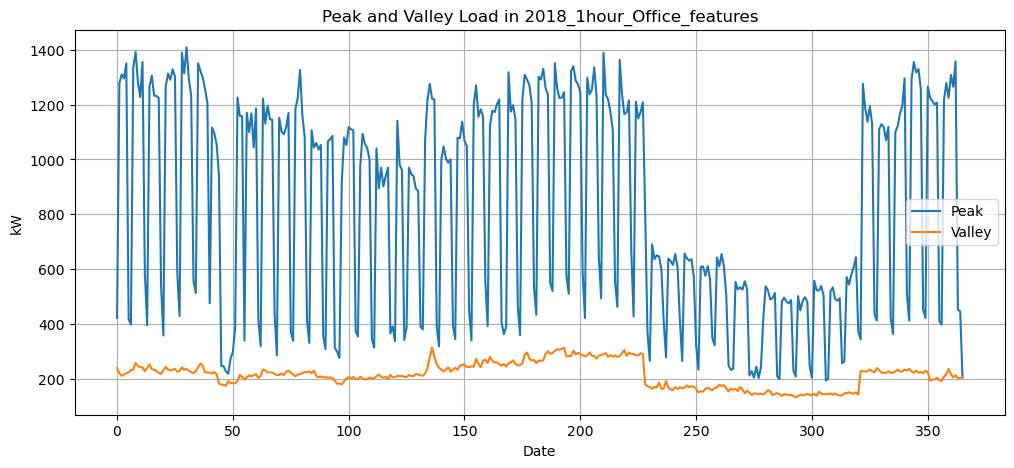

In [32]:
features_df[["peak_load", "valley_load"]].plot(figsize=(12, 5), title="Peak and Valley Load in 2018_1hour_Office_features")
plt.xlabel("Date")
plt.ylabel("kW")
plt.legend(["Peak", "Valley"])
plt.grid(True)
plt.show()

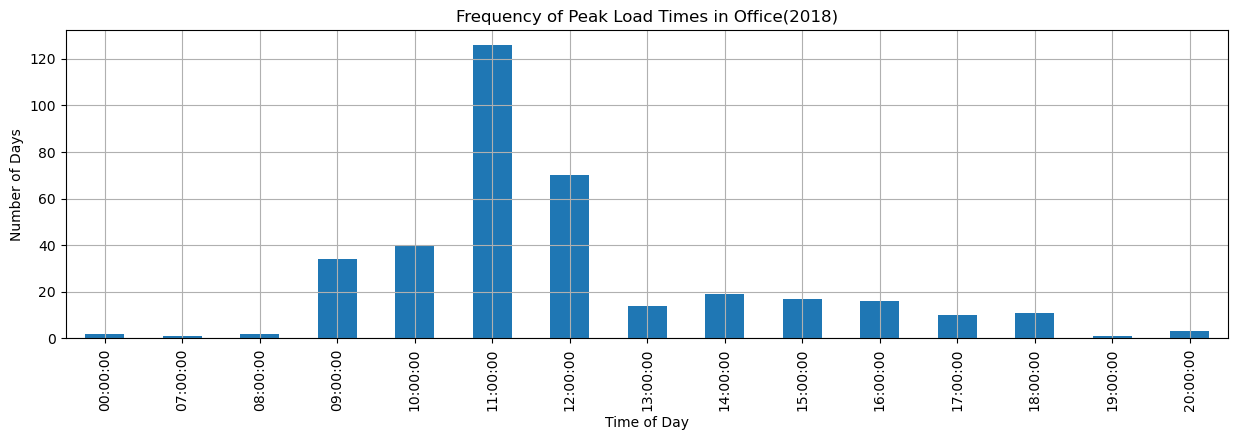

In [33]:
features_df["time_of_peak"].value_counts().sort_index().plot(kind="bar", figsize=(15, 4), title="Frequency of Peak Load Times in Office(2018)")
plt.xlabel("Time of Day")
plt.ylabel("Number of Days")
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

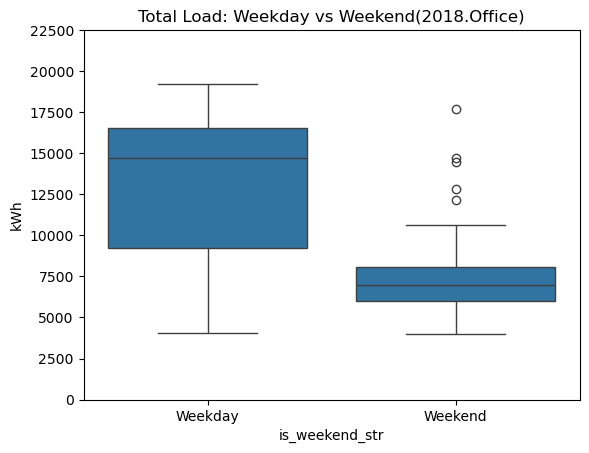

In [37]:
features_df['is_weekend'] = pivot_df_interp['date'].dt.weekday >= 5
features_df['is_weekend_str'] = features_df['is_weekend'].map({True: 'Weekend', False: 'Weekday'})
features_df["is_weekend_str"] = features_df["is_weekend"].map({True: "Weekend", False: "Weekday"})
sns.boxplot(x="is_weekend_str", y="total_load", data=features_df)
plt.title("Total Load: Weekday vs Weekend(2018.Office)")
plt.ylabel("kWh")
plt.ylim(0,22500)
plt.show()


<Figure size 1600x1000 with 0 Axes>

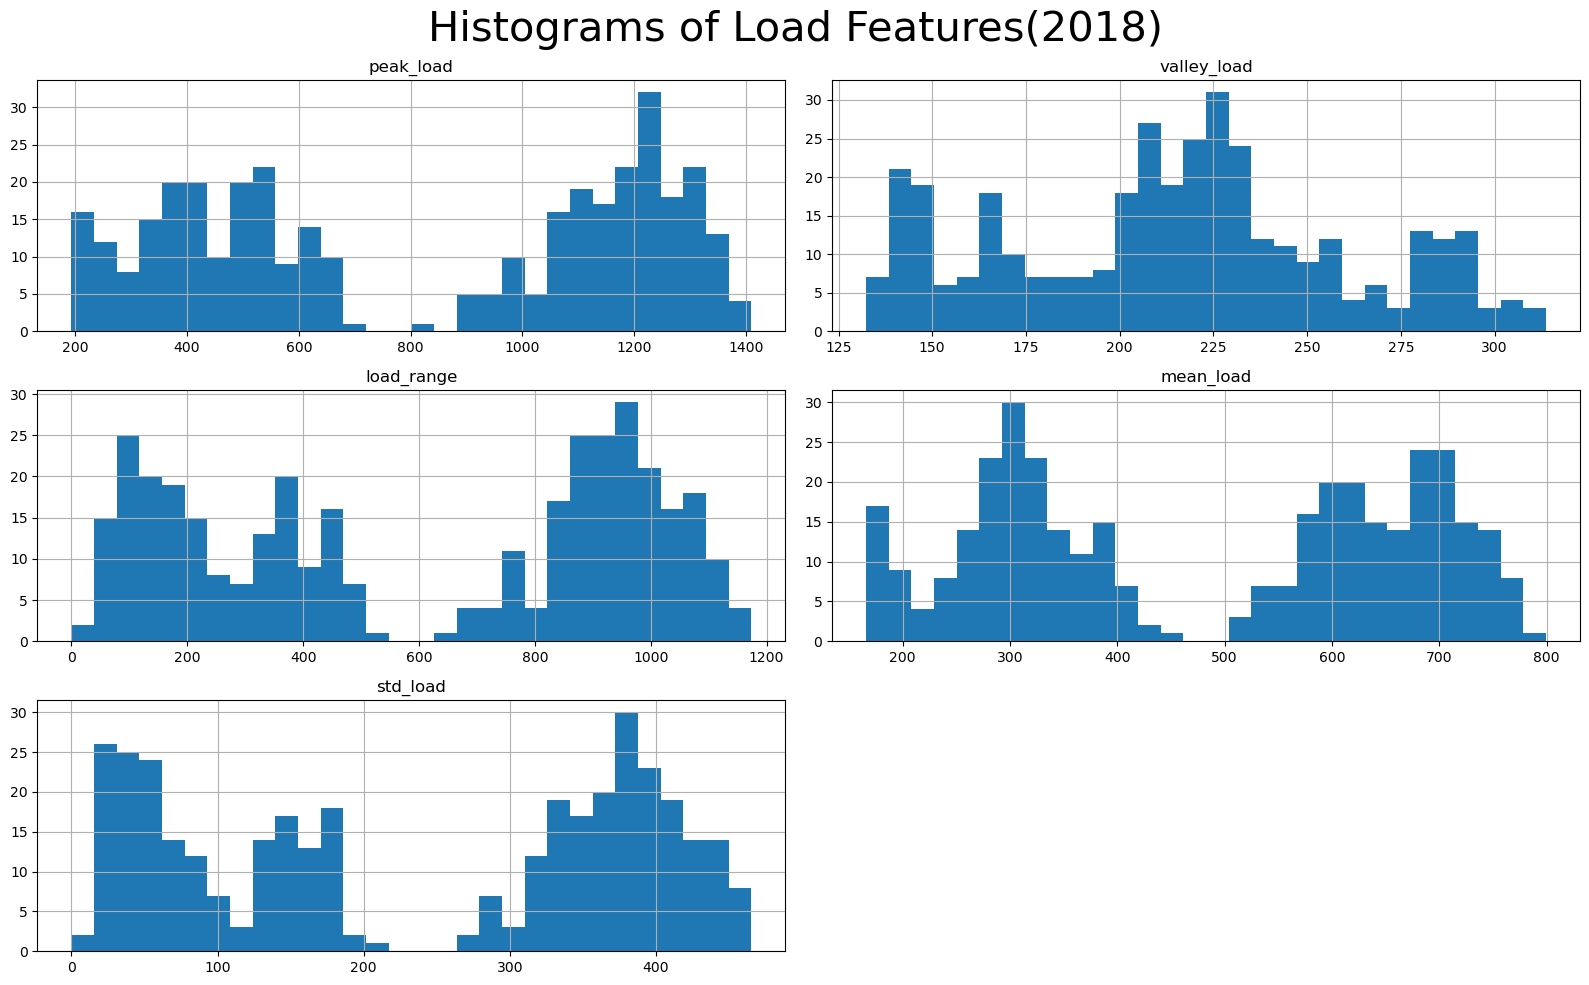

In [39]:
feature_df = pd.DataFrame(index=pivot_df_interp.index)

# 选择中间的负载列（避开 date, cluster 等）
load_columns = [col for col in pivot_df_interp.columns if col not in ['date', 'cluster', 'pattern', 'season']]

feature_df['peak_load'] = pivot_df_interp[load_columns].max(axis=1)
feature_df['valley_load'] = pivot_df_interp[load_columns].min(axis=1)
feature_df['load_range'] = feature_df['peak_load'] - feature_df['valley_load']
feature_df['mean_load'] = pivot_df_interp[load_columns].mean(axis=1)
feature_df['std_load'] = pivot_df_interp[load_columns].std(axis=1)
feature_df['load_factor'] = feature_df['mean_load'] / feature_df['peak_load']
feature_df['peak_time'] = pivot_df_interp[load_columns].idxmax(axis=1)
feature_df['valley_time'] = pivot_df_interp[load_columns].idxmin(axis=1)
plt.figure(figsize=(16, 10))
feature_df[['peak_load', 'valley_load', 'load_range', 'mean_load', 'std_load']].hist(bins=30, figsize=(16, 10))
plt.suptitle("Histograms of Load Features(2018)", fontsize=30)
plt.tight_layout()
plt.show()